In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
# Load
df = pd.read_csv('uganda_traffic_forecasting.csv')

# Dataset preview
print(df.shape)
display(df.head())
display(df.info())

(1538, 11)


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,target_congestion_level
0,2023-01-01 03:00:00,ENT002,23.0,40.72036861283745,Clear,Thursday,0.0,Parade,FAIL,Good,0.0
1,2023-01-01 03:15:00,GUL004,15.0,37.87791030098848,Rainy,Tuesday,0.0,Parade,FAIL,Poor,1.0
2,2023-01-01 03:30:00,GUL004,21.0,30.480815399777644,Clear,Saturday,1.0,Marathon,OK,Moderate,2.0
3,2023-01-01 03:45:00,MBR003,25.0,40.774805185188626,Rainy,Monday,0.0,NaN,UNKNOWN,???,0.0
4,2023-01-01 04:00:00,GUL004,15.0,42.57752540142751,Snowy,Friday,0.0,Marathon,OK,Moderate,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   timestamp                1537 non-null   object
 1   location_id              1534 non-null   object
 2   vehicle_count            1536 non-null   object
 3   avg_speed                1537 non-null   object
 4   weather                  1533 non-null   object
 5   day_of_week              1533 non-null   object
 6   is_holiday               1534 non-null   object
 7   event                    1155 non-null   object
 8   sensor_status            1538 non-null   object
 9   road_condition           1536 non-null   object
 10  target_congestion_level  1537 non-null   object
dtypes: object(11)
memory usage: 132.3+ KB


None

In [3]:
# Calculate missing values
print("\nMissing Values Summary:")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
})

display(missing_summary[missing_summary['Missing Count'] > 0])



Missing Values Summary:


,Missing Count,Missing %
timestamp,1,0.07
location_id,4,0.26
vehicle_count,2,0.13
avg_speed,1,0.07
weather,5,0.33
day_of_week,5,0.33
is_holiday,4,0.26
event,383,24.90
road_condition,2,0.13
target_congestion_level,1,0.07


In [4]:
#  Remove duplicate rows
df.drop_duplicates(inplace=True)

#  Coerce numeric columns read as objects
for col in ['vehicle_count','avg_speed','target_congestion_level','is_holiday']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Standardize anomaly strings to NaN
df.replace(['???','None','none','?','undefined','null'], np.nan, inplace=True)

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Impute missing values
#   Numeric → mean, Categorical → mode, Timestamp → forward fill
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    df[c].fillna(df[c].mode()[0], inplace=True)

df['timestamp'].fillna(method='ffill', inplace=True)

# Final check
print("Missing values per column:\n", df.isna().sum())
print(df.shape)
display(df.info())

Missing values per column:
 timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64
(1466, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 1466 entries, 0 to 1520
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                1466 non-null   datetime64[ns]
 1   location_id              1466 non-null   object        
 2   vehicle_count            1466 non-null   float64       
 3   avg_speed                1466 non-null   float64       
 4   weather                  1466 non-null   object        
 5   day_of_week              1466 non-null   object        
 6   is_holiday               1466 non-

C:\Users\HP ELITEBOOK 840 G5\AppData\Local\Temp\ipykernel_21720\2229911575.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
C:\Users\HP ELITEBOOK 840 G5\AppData\Local\Temp\ipykernel_21720\2229911575.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

None

In [5]:
# Detect and correct outliers using IQR method
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Cap outliers
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply to all numeric columns
num_cols = df.select_dtypes(include=['float64','int64']).columns
df = cap_outliers_iqr(df, num_cols)

# Check for outliers after capping
for col in num_cols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}")

vehicle_count: min=8.0, max=32.0
avg_speed: min=12.634793515760599, max=66.0704726371957
is_holiday: min=0.0, max=1.0
target_congestion_level: min=0.0, max=4.0


In [ ]:
# 4.1 Missing‑value heatmap
plt.figure(figsize=(8,4))
sns.heatmap(df.isna(), cbar=False, cmap='Reds')
plt.title("Missing After Clean")
plt.show()

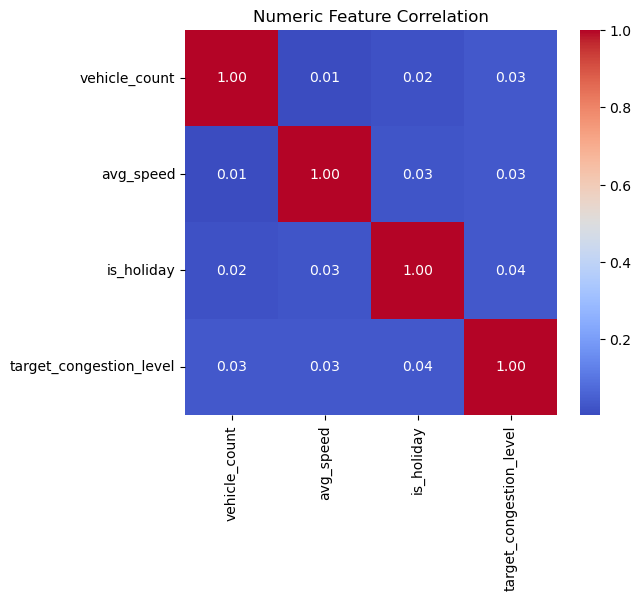

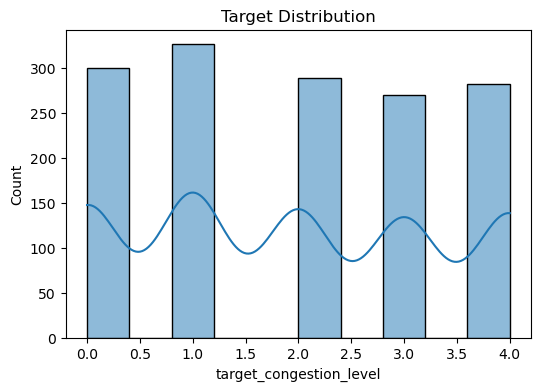

In [6]:
# Correlation of numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Numeric Feature Correlation")
plt.show()

# Distribution of target
plt.figure(figsize=(6,4))
sns.histplot(df['target_congestion_level'], bins=10, kde=True)
plt.title("Target Distribution")
plt.show()

In [18]:
df_feat = df.copy()

# Time‑based
df_feat['hour']      = df_feat['timestamp'].dt.hour
df_feat['weekday']   = df_feat['timestamp'].dt.weekday      # 0=Mon
df_feat['is_weekend']= df_feat['weekday'].isin([5,6]).astype(int)
df_feat['month']     = df_feat['timestamp'].dt.month

# Cyclical encoding for hour and month
df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour']/24)
df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour']/24)
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month']/12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month']/12)

# Traffic dynamics
df_feat['speed_per_vehicle'] = df_feat['avg_speed'] / (df_feat['vehicle_count']+1)
df_feat['veh_density']       = df_feat['vehicle_count'] / (df_feat['hour']+1)

# Lag features (previous hour's vehicle count and avg speed)
df_feat = df_feat.sort_values('timestamp')
df_feat['vehicle_count_lag1'] = df_feat['vehicle_count'].shift(1)
df_feat['avg_speed_lag1'] = df_feat['avg_speed'].shift(1)

# Rolling mean features (3-hour window)
df_feat['vehicle_count_roll3'] = df_feat['vehicle_count'].rolling(window=3, min_periods=1).mean()
df_feat['avg_speed_roll3'] = df_feat['avg_speed'].rolling(window=3, min_periods=1).mean()

# Interaction
df_feat['weather_road'] = df_feat['weather'] + '_' + df_feat['road_condition']

# Classification target
df_feat['congestion_class'] = pd.cut(
    df_feat['target_congestion_level'],
    bins=[-1,1.5,3.5,5],
    labels=[0,1,2]
).astype(int)

# Drop rows with NA from lag/rolling features (first few rows)
df_feat = df_feat.dropna().reset_index(drop=True)

# Additional Feature Engineering

# Interaction features
df_feat['speed_flow'] = df_feat['avg_speed'] * df_feat['vehicle_count']
df_feat['holiday_weekend'] = df_feat['is_holiday'] * df_feat['is_weekend']
df_feat['holiday_density'] = df_feat['veh_density'] * df_feat['is_holiday']

# More lag features
df_feat['vehicle_count_lag2'] = df_feat['vehicle_count'].shift(2)
df_feat['avg_speed_lag2'] = df_feat['avg_speed'].shift(2)

# Rolling statistics (window=3)
df_feat['vehicle_count_roll3_min'] = df_feat['vehicle_count'].rolling(window=3, min_periods=1).min()
df_feat['vehicle_count_roll3_max'] = df_feat['vehicle_count'].rolling(window=3, min_periods=1).max()
df_feat['avg_speed_roll3_min'] = df_feat['avg_speed'].rolling(window=3, min_periods=1).min()
df_feat['avg_speed_roll3_max'] = df_feat['avg_speed'].rolling(window=3, min_periods=1).max()

# Change detection
df_feat['delta_vehicle_count'] = df_feat['vehicle_count'] - df_feat['vehicle_count_lag1']
df_feat['delta_avg_speed'] = df_feat['avg_speed'] - df_feat['avg_speed_lag1']

# Temporal features
df_feat['day_of_year'] = df_feat['timestamp'].dt.dayofyear
df_feat['week_of_year'] = df_feat['timestamp'].dt.isocalendar().week

# Drop rows with NA from new lag/rolling features (first few rows)
df_feat = df_feat.dropna().reset_index(drop=True)

# Review new features
display(df_feat.head())

# Review
display(df_feat.head())


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,...,vehicle_count_lag2,avg_speed_lag2,vehicle_count_roll3_min,vehicle_count_roll3_max,avg_speed_roll3_min,avg_speed_roll3_max,delta_vehicle_count,delta_avg_speed,day_of_year,week_of_year
0,2023-01-01 03:45:00,MBR003,25.0,40.774805,Rainy,Monday,0.0,Accident,UNKNOWN,Good,...,15.0,37.877910,15.0,25.0,30.480815,40.774805,4.0,10.293990,1,52
1,2023-01-01 04:00:00,GUL004,15.0,42.577525,Snowy,Friday,0.0,Marathon,OK,Moderate,...,21.0,30.480815,15.0,25.0,30.480815,42.577525,-10.0,1.802720,1,52
2,2023-01-01 04:30:00,ENT002,19.0,43.341764,Foggy,Wednesday,0.0,Accident,UNKNOWN,Good,...,25.0,40.774805,15.0,25.0,40.774805,43.341764,4.0,0.764239,1,52
3,2023-01-01 04:45:00,MBR003,21.0,38.447410,Clear,Friday,1.0,Parade,OK,Poor,...,15.0,42.577525,15.0,21.0,38.447410,43.341764,2.0,-4.894355,1,52
4,2023-01-01 05:00:00,KLA001,17.0,20.921924,Rainy,Friday,0.0,Accident,FAIL,Moderate,...,19.0,43.341764,17.0,21.0,20.921924,43.341764,-4.0,-17.525485,1,52


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,...,vehicle_count_lag2,avg_speed_lag2,vehicle_count_roll3_min,vehicle_count_roll3_max,avg_speed_roll3_min,avg_speed_roll3_max,delta_vehicle_count,delta_avg_speed,day_of_year,week_of_year
0,2023-01-01 03:45:00,MBR003,25.0,40.774805,Rainy,Monday,0.0,Accident,UNKNOWN,Good,...,15.0,37.877910,15.0,25.0,30.480815,40.774805,4.0,10.293990,1,52
1,2023-01-01 04:00:00,GUL004,15.0,42.577525,Snowy,Friday,0.0,Marathon,OK,Moderate,...,21.0,30.480815,15.0,25.0,30.480815,42.577525,-10.0,1.802720,1,52
2,2023-01-01 04:30:00,ENT002,19.0,43.341764,Foggy,Wednesday,0.0,Accident,UNKNOWN,Good,...,25.0,40.774805,15.0,25.0,40.774805,43.341764,4.0,0.764239,1,52
3,2023-01-01 04:45:00,MBR003,21.0,38.447410,Clear,Friday,1.0,Parade,OK,Poor,...,15.0,42.577525,15.0,21.0,38.447410,43.341764,2.0,-4.894355,1,52
4,2023-01-01 05:00:00,KLA001,17.0,20.921924,Rainy,Friday,0.0,Accident,FAIL,Moderate,...,19.0,43.341764,17.0,21.0,20.921924,43.341764,-4.0,-17.525485,1,52


In [19]:
# --- Evaluate the impact of new features on model performance ---

# 1. Baseline: Only original features (no engineered features)
base_features = ['vehicle_count', 'avg_speed', 'is_holiday', 'weather', 'road_condition', 'location_id']  # removed 'timestamp'
df_base = df.copy()
df_base = df_base.dropna(subset=base_features)  # drop rows with missing base features
X_base = pd.get_dummies(df_base[base_features], columns=['weather','road_condition','location_id'], drop_first=True)
y_base = pd.cut(df_base['target_congestion_level'], bins=[-1,1.5,3.5,5], labels=[0,1,2]).astype(int)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)
rf_base = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced')
rf_base.fit(Xb_train, yb_train)
yb_pred = rf_base.predict(Xb_test)
print('Baseline (no engineered features) Accuracy:', accuracy_score(yb_test, yb_pred))
print(classification_report(yb_test, yb_pred))


# 2. With engineered features (including new features)
features = [
    'vehicle_count','avg_speed','is_holiday','is_weekend',
    'hour','weekday','veh_density','speed_per_vehicle','weather_road','location_id',
    'speed_flow','holiday_weekend','holiday_density',
    'vehicle_count_lag1','avg_speed_lag1','vehicle_count_lag2','avg_speed_lag2',
    'vehicle_count_roll3','avg_speed_roll3',
    'vehicle_count_roll3_min','vehicle_count_roll3_max',
    'avg_speed_roll3_min','avg_speed_roll3_max',
    'delta_vehicle_count','delta_avg_speed',
    'day_of_year','week_of_year'
]

df_model = pd.get_dummies(df_feat[features + ['congestion_class']], columns=['weather_road','location_id'], drop_first=True)
X_eng = df_model.drop('congestion_class', axis=1)
y_eng = df_model['congestion_class']
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng)
rf_eng = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced')
rf_eng.fit(Xe_train, ye_train)
ye_pred = rf_eng.predict(Xe_test)
print('With engineered features Accuracy:', accuracy_score(ye_test, ye_pred))
print(classification_report(ye_test, ye_pred))

# 3. Compare results
print('Improvement in accuracy:', accuracy_score(ye_test, ye_pred) - accuracy_score(yb_test, yb_pred))

Baseline (no engineered features) Accuracy: 0.40816326530612246
              precision    recall  f1-score   support

           0       0.44      0.58      0.50       125
           1       0.40      0.38      0.39       112
           2       0.22      0.11      0.14        57

    accuracy                           0.41       294
   macro avg       0.36      0.35      0.34       294
weighted avg       0.38      0.41      0.39       294

With engineered features Accuracy: 0.48464163822525597
              precision    recall  f1-score   support

           0       0.49      0.65      0.56       125
           1       0.48      0.46      0.47       112
           2       0.50      0.16      0.24        56

    accuracy                           0.48       293
   macro avg       0.49      0.42      0.42       293
weighted avg       0.49      0.48      0.46       293

Improvement in accuracy: 0.07647837291913351


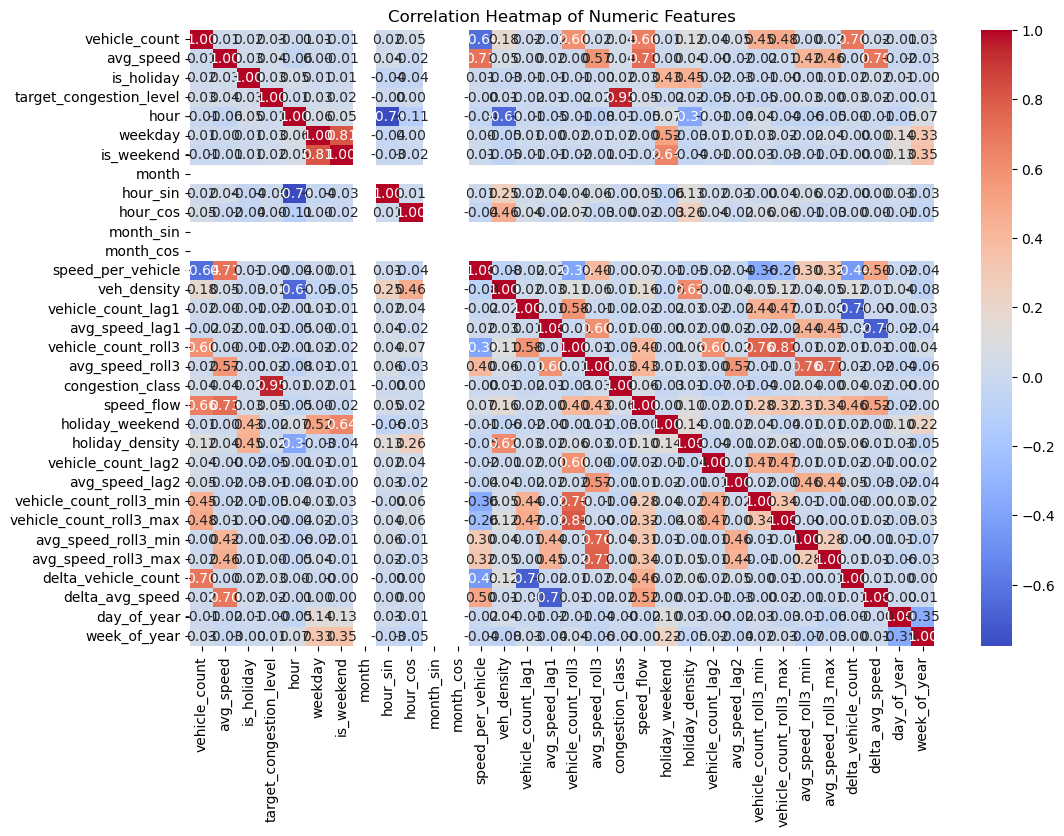

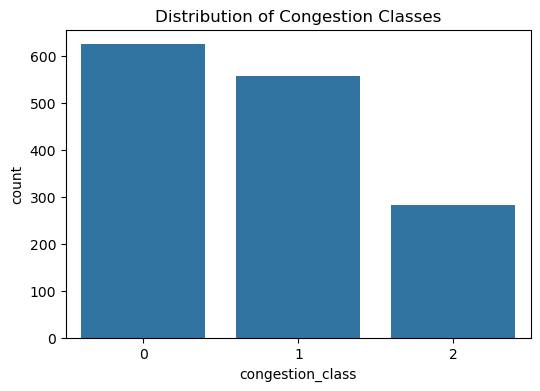

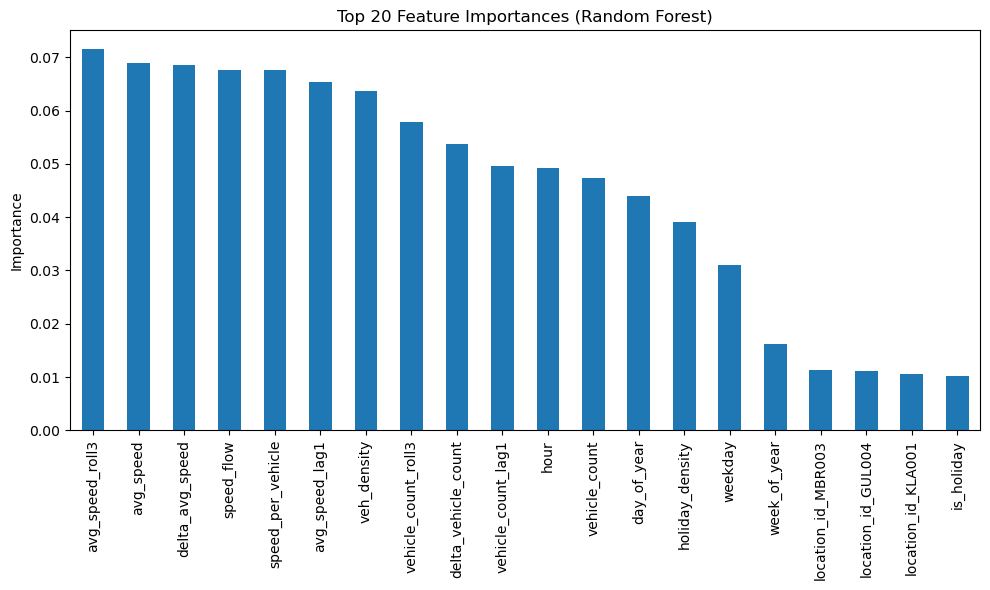

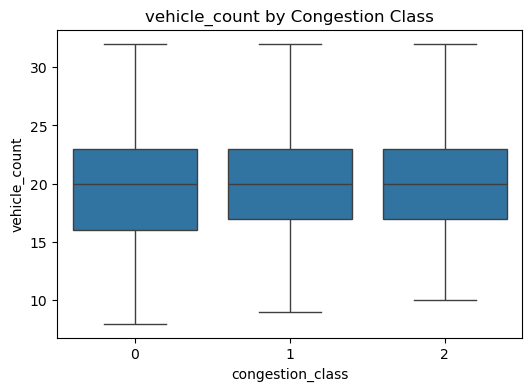

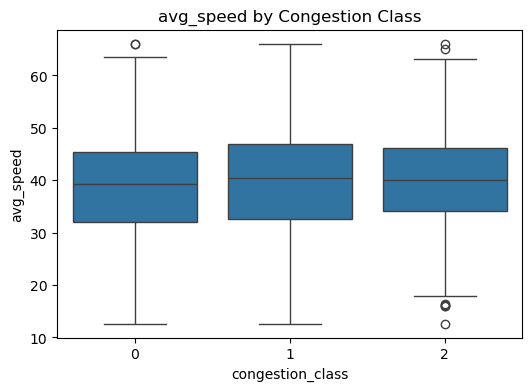

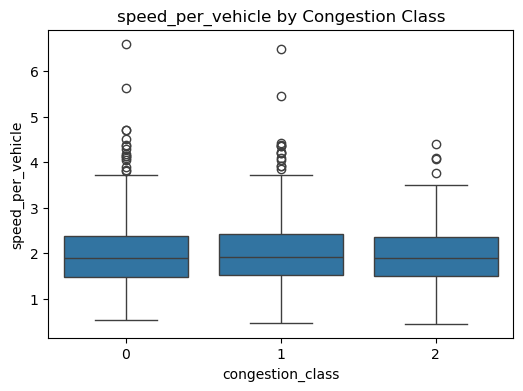

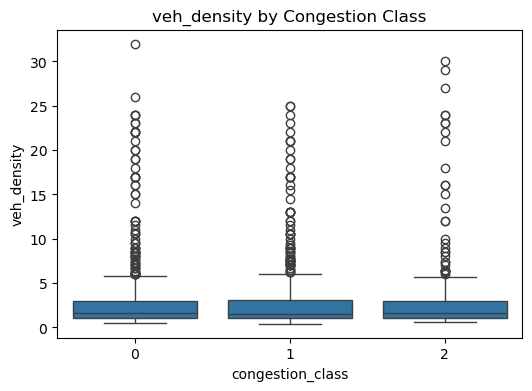

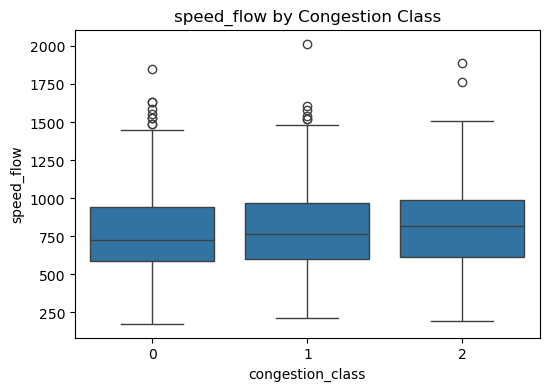

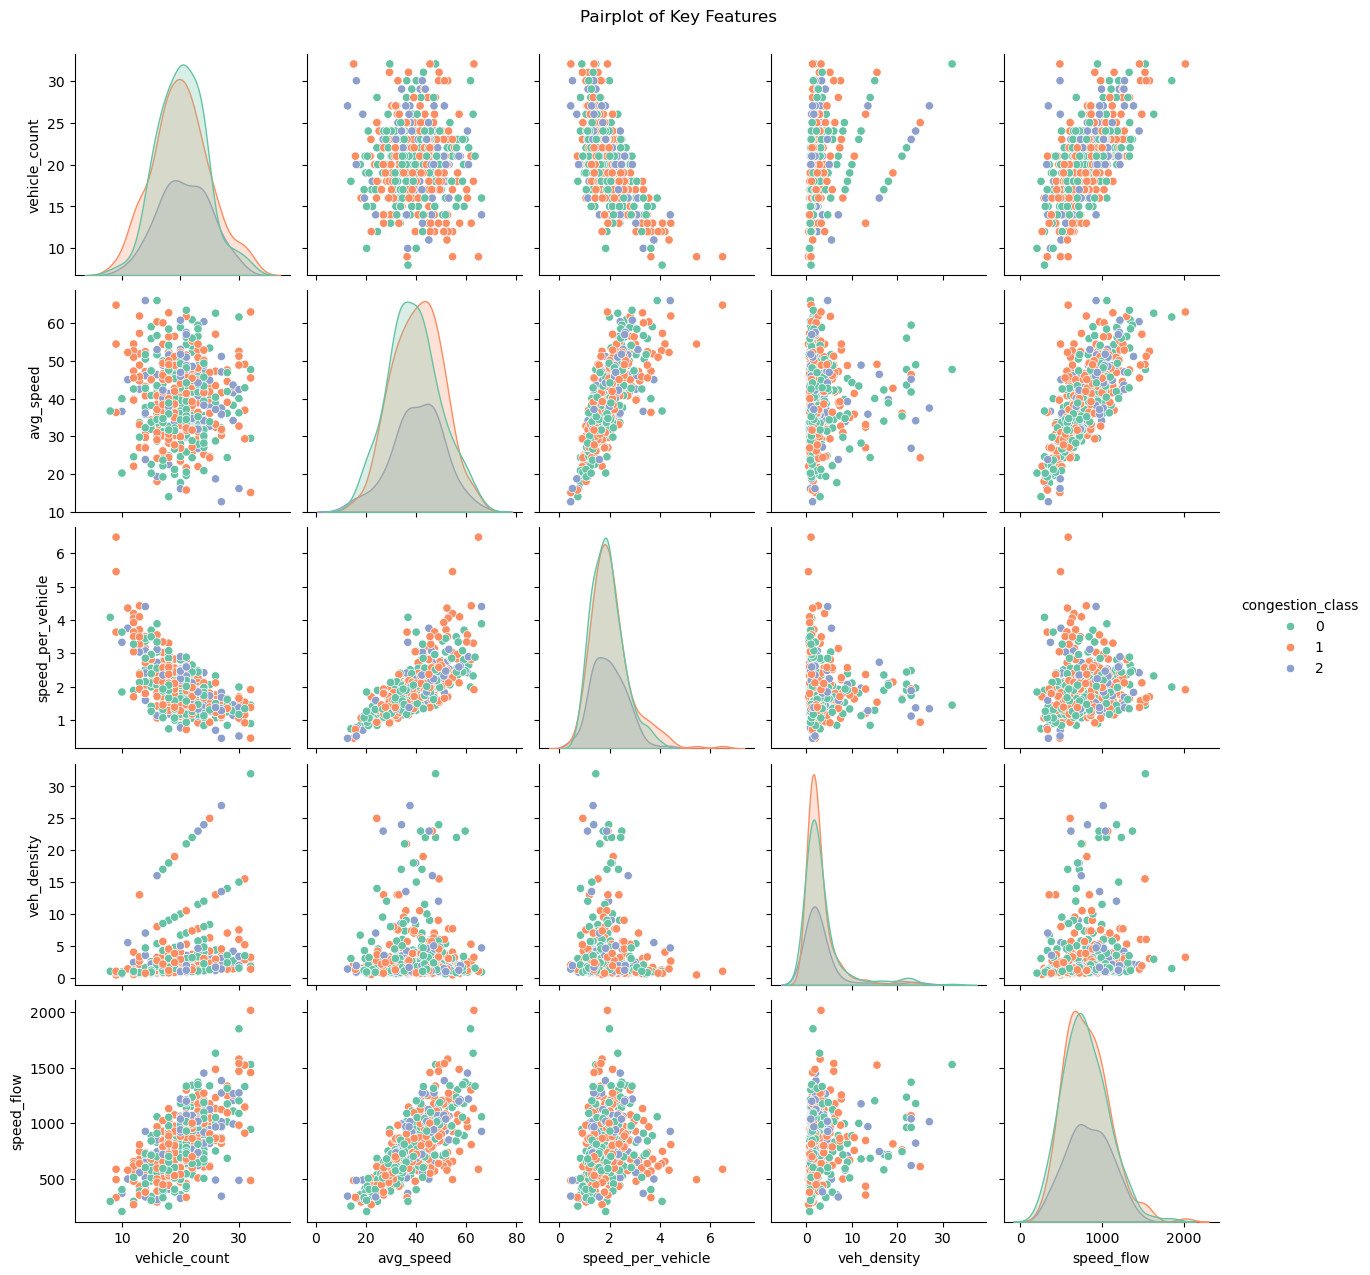

In [20]:
# 1. Correlation heatmap of all numeric features (including engineered)
plt.figure(figsize=(12,8))
sns.heatmap(df_feat.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 2. Distribution of the target variable (congestion_class)
plt.figure(figsize=(6,4))
sns.countplot(x='congestion_class', data=df_feat)
plt.title("Distribution of Congestion Classes")
plt.show()

# 3. Feature importance plot using Random Forest (all engineered features)
features_for_importance = [
    'vehicle_count', 'avg_speed', 'is_holiday', 'is_weekend',
    'hour', 'weekday', 'veh_density', 'speed_per_vehicle',
    'speed_flow', 'holiday_weekend', 'holiday_density',
    'vehicle_count_lag1', 'avg_speed_lag1',
    'vehicle_count_roll3', 'avg_speed_roll3',
    'delta_vehicle_count', 'delta_avg_speed',
    'day_of_year', 'week_of_year',
    'weather_road', 'location_id'
]
df_model_imp = pd.get_dummies(df_feat[features_for_importance + ['congestion_class']], columns=['weather_road','location_id'], drop_first=True)
X_imp = df_model_imp.drop('congestion_class', axis=1)
y_imp = df_model_imp['congestion_class']
rf_imp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_imp.fit(X_imp, y_imp)
importances = pd.Series(rf_imp.feature_importances_, index=X_imp.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 4. Boxplots for key numeric features by congestion class
key_numeric = ['vehicle_count', 'avg_speed', 'speed_per_vehicle', 'veh_density', 'speed_flow']
for col in key_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='congestion_class', y=col, data=df_feat)
    plt.title(f'{col} by Congestion Class')
    plt.show()

# 5. Pairplot for selected features (sampled for speed)
sample = df_feat.sample(n=min(500, len(df_feat)), random_state=42)
sns.pairplot(sample, vars=key_numeric, hue='congestion_class', palette='Set2')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

🔍 Random Forest Accuracy: 0.44368600682593856
              precision    recall  f1-score   support

           0       0.48      0.58      0.53       125
           1       0.45      0.38      0.41       112
           2       0.32      0.25      0.28        56

    accuracy                           0.44       293
   macro avg       0.41      0.41      0.41       293
weighted avg       0.44      0.44      0.44       293

📊 5-fold CV Accuracy: 0.3937397727804012


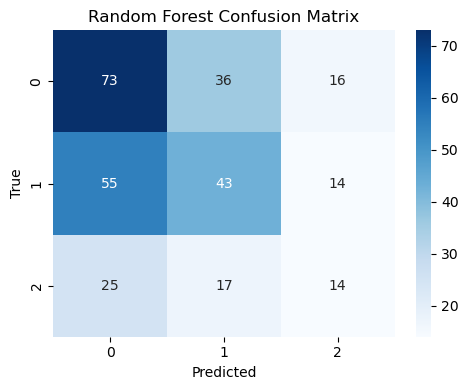

c:\Users\HP ELITEBOOK 840 G5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:21:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔥 XGBoost Accuracy: 0.447098976109215
              precision    recall  f1-score   support

           0       0.51      0.58      0.54       125
           1       0.42      0.47      0.45       112
           2       0.23      0.11      0.15        56

    accuracy                           0.45       293
   macro avg       0.39      0.39      0.38       293
weighted avg       0.42      0.45      0.43       293



In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use only top features based on feature importance
top_features = [
    'avg_speed_roll3', 'avg_speed', 'delta_avg_speed', 'speed_flow',
    'speed_per_vehicle', 'avg_speed_lag1', 'veh_density',
    'vehicle_count_roll3', 'vehicle_count_lag1', 'hour',
    'vehicle_count', 'day_of_year', 'holiday_density',
    'weekday', 'week_of_year'
]

# Prepare data
df_model = df_feat[top_features].copy()
X = df_model.astype(float)
y = df_feat['congestion_class']

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest Classifier (weighted for class imbalance)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    class_weight={0: 1, 1: 1, 2: 3}
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('🔍 Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print('📊 5-fold CV Accuracy:', cv_scores.mean())

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# XGBoost (use class weight for minority class)
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print('🔥 XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
